# Ford A Dataset. A Supervised TS Classification Problem

The goal is to automatically detect the presence of a specific issue with the engine. The problem is a balanced binary classification task

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Sólo en mi local
# %pip install protobuf==3.20.*

  Using cached protobuf-3.20.3-cp39-cp39-win_amd64.whl (904 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\MRM\\miniconda3\\Lib\\site-packages\\google\\~-pb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [4]:

#export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import keras
print(keras.__version__)
import os, pathlib, shutil, random, urllib, zipfile
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


2.15.0


## 0. URL and Information about the dataset
url = 'http://timeseriesclassification.com/description.php?Dataset=FordA'


Train Size = 3601
Test Size = 1320
Length = 500
N_of_classes = 2
Number of Dimensions = 1

## 1- Download and unzip dataset

In [3]:

os.chdir('/content/drive/MyDrive/Colab_Notebooks/TimeSeries')
'''
url = "http://timeseriesclassification.com/ClassificationDownloads/FordA.zip"
extract_dir = "FordA"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)
    '''

'\nurl = "http://timeseriesclassification.com/ClassificationDownloads/FordA.zip"\nextract_dir = "FordA"\n\nzip_path, _ = urllib.request.urlretrieve(url)\nwith zipfile.ZipFile(zip_path, "r") as f:\n    f.extractall(extract_dir)\n    '

## 2. Load train and test in pandas and split the dataset into Labels and TS

In [5]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


In [7]:
'''
# Load Train and Test datasets in Pandas
train = pd.read_table('./FordA/FordA_TRAIN.txt',sep = '\s+', header = None)
test = pd.read_table('./FordA/FordA_TEST.txt', sep = '\s+',header = None)

# First column is the label and the rest of the columns are the Timestamps for each signal
train.head()

# Convert to numpy arrays
X_train, y_train = train.iloc[:,1:].values, train.iloc[:,0].values.astype('int64')
X_test, y_test = test.iloc[:,1:].values, test.iloc[:,0].values.astype('int64')

X_train.shape

SyntaxError: incomplete input (<ipython-input-7-1626856e395b>, line 1)

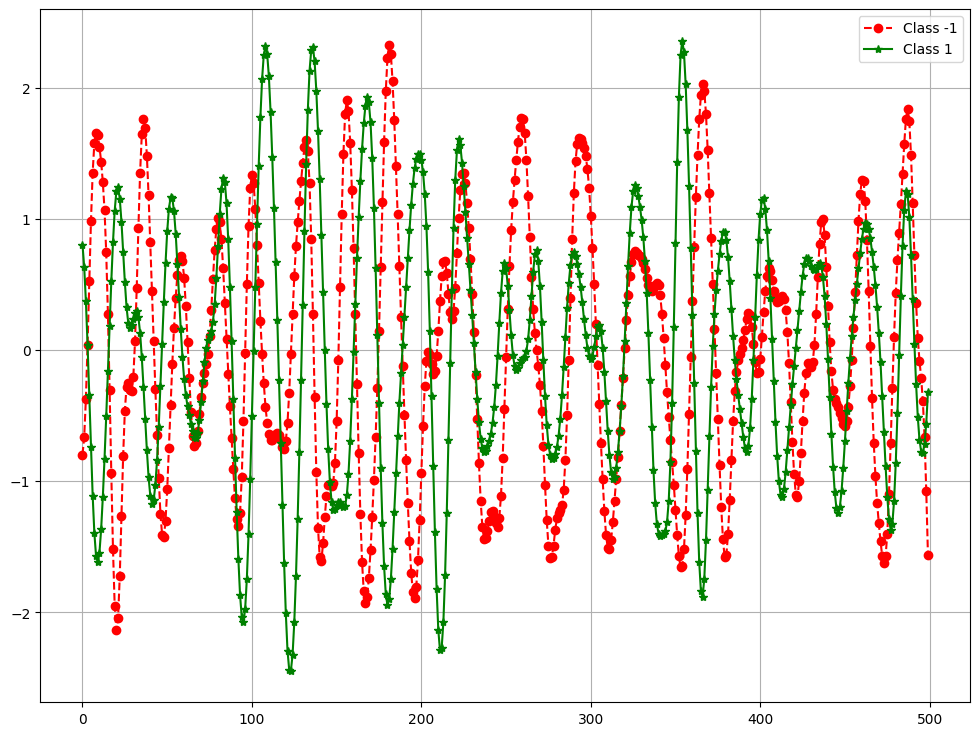

In [5]:
# Plot a couple of signals
# Each row is a time series beign measured

fig,ax = plt.subplots(figsize = (12,9))
ax.plot(np.arange(0,x_train.shape[1]), x_train[0,:], label = 'Class -1', c ='r', marker = 'o', ls = '--')
ax.plot(np.arange(0,x_train.shape[1]), x_train[1,:], label = 'Class 1', c= 'g', marker = '*', ls='-')
plt.legend(loc = 'best')
plt.grid(True)
plt.show()

## 3. Normaliza Data
 For this specific dataset, the data is already z-normalized: each timeseries sample has a mean equal to zero and a standard deviation equal to one.
 This type of normalization is very common for timeseries classification problems, see Bagnall et al. (2016).

## 4. Approach using CONV1D a Full Convolutional Network

In order to consider the problem as a multivariate problem with a Conv1D, We perform a reshaping on the previous arrays. We need 3D Arrays


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

### Model

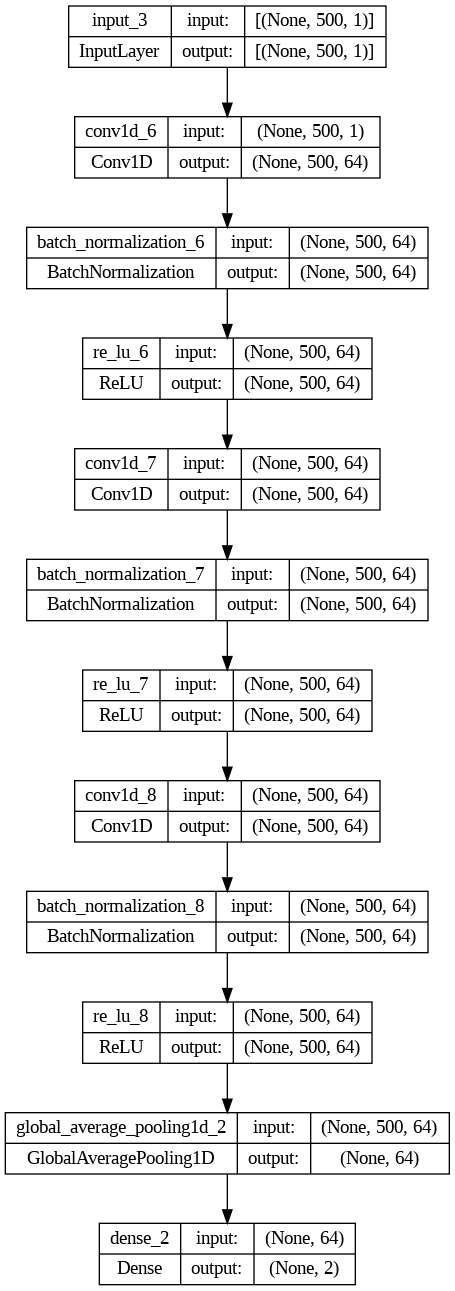

In [23]:
def make_conv1D_model(input_shape):
    input_layer = layers.Input(input_shape)
    # First Conv Block
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_conv1D_model(input_shape=X_train.shape[1:])
epochs = 400
batch_size = 32

callbacks = [keras.callbacks.ModelCheckpoint('FordA_conv1d.keras', save_best_only=True,monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
             ]
keras.utils.plot_model(model, show_shapes=True)

In [24]:
#Train the model

#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=100,
#    decay_rate=0.9)

model.compile(optimizer = 'adam',  loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"])

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/400
90/90 [==============================] - 3s 11ms/step - loss: 0.5686 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.8233 - val_sparse_categorical_accuracy: 0.4979 - lr: 0.0010
Epoch 2/400
90/90 [==============================] - 1s 6ms/step - loss: 0.4626 - sparse_categorical_accuracy: 0.7781 - val_loss: 0.8341 - val_sparse_categorical_accuracy: 0.4979 - lr: 0.0010
Epoch 3/400
90/90 [==============================] - 1s 6ms/step - loss: 0.4392 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.8386 - val_sparse_categorical_accuracy: 0.4979 - lr: 0.0010
Epoch 4/400
90/90 [==============================] - 1s 7ms/step - loss: 0.4244 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.5243 - lr: 0.0010
Epoch 5/400
90/90 [==============================] - 1s 9ms/step - loss: 0.4090 - sparse_categorical_accuracy: 0.8003 - val_loss: 0.6494 - val_sparse_categorical_accuracy: 0.5479 - lr: 0.0010
Epoch 6/400
90/90 [====================

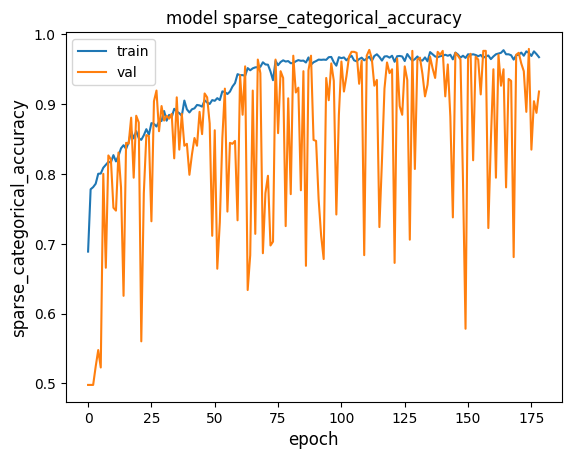

In [25]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [26]:
model = keras.models.load_model("FordA_conv1d.keras")

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 6ms/step - loss: 0.1015 - sparse_categorical_accuracy: 0.9682
Test accuracy 0.9681817889213562
Test loss 0.10154341161251068


TRY OTHER MODELS, LSTM, GRU, ATTENTION + CONV1D, ATTENTION + GRU, ATTENTION + LSTM, PURE TRANSFORMER ENCODER FOR CLASSIFICATION

# 2 Classification with LSTM

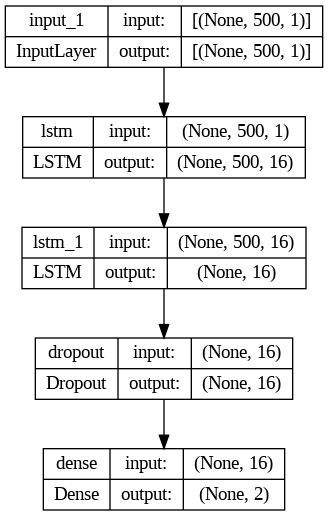

In [7]:
def make_LSTM_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    x = keras.layers.LSTM(16, recurrent_dropout=0.2,return_sequences=True)(input_layer)
    x = keras.layers.LSTM(16, recurrent_dropout = 0.2)(x)
    x = layers.Dropout(0.2)(x)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model_LSTM = make_LSTM_model(input_shape=X_train.shape[1:])
epochs = 300
batch_size = 32

callbacks = [keras.callbacks.ModelCheckpoint('FordA_LSTM.keras', save_best_only=True,monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
             ]
keras.utils.plot_model(model_LSTM, show_shapes=True)

In [ ]:
#Train the model

model_LSTM.compile(optimizer = 'adam',  loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"])

history_LSTM = model_LSTM.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history_LSTM.history[metric])
plt.plot(history_LSTM.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# 3 Classification with GRU

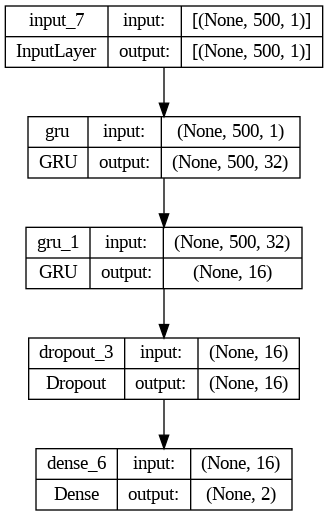

In [31]:
def make_GRU_model(input_shape):
    input_layer = layers.Input(input_shape)

    x = keras.layers.GRU(32, recurrent_dropout = 0.2,return_sequences=True)(input_layer)
    x = keras.layers.GRU(16, recurrent_dropout = 0.2)(x)
    x = layers.Dropout(0.2)(x)

    output_layer = keras.layers.Dense(n_classes, activation="softmax")(x)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model_GRU = make_GRU_model(input_shape=X_train.shape[1:])
epochs = 300
batch_size = 32

callbacks = [keras.callbacks.ModelCheckpoint('FordA_GRU.keras', save_best_only=True,monitor="val_loss"),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.001),
             keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
             ]
keras.utils.plot_model(model_GRU, show_shapes=True)

In [ ]:
#Train the model

model_GRU.compile(optimizer = 'adam',  loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"])

history_GRU = model_GRU.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history_GRU.history[metric])
plt.plot(history_GRU.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

# 4 Classification with Attention + CONV 1D Encoder

Our model processes a tensor of shape (batch size, sequence length, features), where sequence length is the number of time steps and features is each input timeseries.

You can replace your classification RNN layers with this one: the inputs are fully compatible!

We include residual connections, layer normalization, and dropout. The resulting layer can be stacked multiple times.

The projection layers are implemented through keras.layers.Conv1D.

In [21]:
def transformer_encoder_CONV1D(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    ):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_CONV1D(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)

    print(x.shape)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [17]:

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [18]:
x_train.shape[1:]

(500, 1)

In [22]:
input_shape = x_train.shape[1:]

model_encoder_conv1D = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_encoder_conv1D.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model_encoder_conv1D.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_encoder_conv1D.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model_encoder_conv1D.evaluate(x_test, y_test, verbose=1)

(None, 128)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 500, 1)]             0         []                            
                                                                                                  
 multi_head_attention_5 (Mu  (None, 500, 1)               7169      ['input_6[0][0]',             
 ltiHeadAttention)                                                   'input_6[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 500, 1)               0         ['multi_head_attention_5[0][0]
                                                                    ']                            
                                                                                

[0.692997395992279, 0.5159090757369995]

# 5 Classification with Attention + GRU Encoder

In [9]:
def transformer_encoder_GRU(inputs, head_size, num_heads, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.GRU(16, recurrent_dropout = 0.2,return_sequences=True)(res)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

def build_model_GRU(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_GRU(x, head_size, num_heads, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x) # Ver si esto funciona con GRU ???
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)

    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [10]:
input_shape = x_train.shape[1:]

model_encoder_GRU = build_model_GRU(
    input_shape,
    head_size=256,
    num_heads=3,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_encoder_GRU.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model_encoder_GRU.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_encoder_GRU.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model_encoder_GRU.evaluate(x_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500, 1)]             0         []                            
                                                                                                  
 multi_head_attention_4 (Mu  (None, 500, 1)               5377      ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 500, 1)               0         ['multi_head_attention_4[0][0]
                                                                    ']                            
                                                                                            

KeyboardInterrupt: 

# 6 Classification with Attention + LSTM Encoder

In [ ]:
def transformer_encoder_LSTM(inputs, head_size, num_heads, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.LSTM(8, recurrent_dropout=0.2,return_sequences=True)(res)
    x = layers.Dropout(0.2)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

def build_model_LSTM(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_LSTM(x, head_size, num_heads, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x) # Ver si esto funciona con GRU ???
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = x_train.shape[1:]

model_encoder_LSTM = build_model_LSTM(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_encoder_LSTM.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model_encoder_GRU.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model_encoder_LSTM.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model_encoder_LSTM.evaluate(x_test, y_test, verbose=1)